# Similarity renormalization group (SRG)

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ March 25, 2022

Visualizes SRG evolution by plotting contours of evolved potentials. Several references on the SRG are given below:
* S. K. Bogner, R. J. Furnstahl, and R. J. Perry, [Phys. Rev. C __75__, 061001 (2007)](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.75.061001).
* S. K. Bogner, R. J. Furnstahl, and A. Schwenk, [Prog. Part. Nucl. Phys. __65__, 94 (2010)](https://www.sciencedirect.com/science/article/pii/S0146641010000347?via%3Dihub).
* R. J. Furnstahl and K. Hebeler, [Rept. Prog. Phys. __76__, 126301 (2013)](https://iopscience.iop.org/article/10.1088/0034-4885/76/12/126301).
* H. Hergert, S. K. Bogner, J. G. Lietz, T. D. Morris, S. Novario, N. M. Parzuchowski, and F. Yuan, [Lect. Notes Phys. __936__, 477 (2017)](https://link.springer.com/chapter/10.1007/978-3-319-53336-0_10).

_Last update:_ June 22, 2022

__To-do list:__
* Add option for other sub-blocks of coupled-channel potentials (e.g., $^{3}\rm{S}_1$-$^{3}\rm{D}_1$).

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
# Imports from A.T. codes
from scripts.figures import (
    set_rc_parameters, interpolate_matrix, label_channel, label_generator,
    label_kvnn, label_lambda, label_ticks
)
from scripts.potentials import Potential
from scripts.tools import convert_number_to_string, replace_periods

## Set-up

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

In [4]:
# Save figures in the following directory
figures_directory = '../figures/srg/'

## Plotting functions

In [5]:
def potential_contour(
        kvnn, channel, kmax, kmid, ntot, generator=None, lamb=None,
        k_squared=False, levels_number=61, colorbar_limits=(-1.0,1.0),
        color_map='turbo', axes_limits=(0.0,4.0), xlabel_size=16,
        ylabel_size=16, channel_label=False, generator_label=False,
        kvnn_label=False, lambda_label=False, save=False):
    """
    Plots the matrix elements of a potential with respect to k and k' as a
    contour plot.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel (e.g. '1S0').
    kmax : float
        Maximum value in the momentum mesh [fm^-1].
    kmid : float
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int
        Number of momentum points in mesh.
    generator : str, optional
        SRG generator 'Wegner', 'T', or 'Block-diag'. The default value is
        None corresponding to the unevolved potential.
    lamb : float, optional
        SRG evolution parameter \lambda [fm^-1]. The default value is None
        corresponding to the unevolved potential.
    k_squared : bool, optional
        Option to plot the potential with respect to k^2 and k'^2.
    levels_number : int, optional
        Number of contour levels.
    colorbar_limits : tuple, optional
        Lower and upper limits of the colorbar.
    color_map : str, optional
        The colormap for confourf plots.
    axes_limits : tuple, optional
        Limits for the k and k' axes [fm^-1].
    xlabel_size : int, optional
        Fontsize for the x-axis label.
    ylabel_size : int, optional
        Fontsize for the y-axis label.
    channel_label : bool, optional
        Option to add a channel label on the figure as an anchored text.
    generator_label : bool, optional
        Option to add an SRG generator label on the figure as an anchored
        text.
    kvnn_label : bool, optional
        Option to add a kvnn label on the figure as an anchored text.
    lambda_label : bool, optional
        Option to add a \lambda or \Lambda_BD label on the figure as an
        anchored text.
    save : bool, optional
        Option to save the figure.
    
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))
    
    # Set contour levels
    levels = np.linspace(colorbar_limits[0], colorbar_limits[1],
                         levels_number)
    
    # --- Get data --- #
    # Initialize potential object and get its momentum mesh
    potential = Potential(kvnn, channel, kmax, kmid, ntot)
    k_array, _ = potential.load_mesh()
    
    # Initial potential
    if generator is None:
        V_matrix = potential.load_potential()
    # SRG-evolved with block-diagonal generator
    elif generator == 'Block-diag':
        V_matrix = potential.load_potential('srg', generator, 1.0, lamb)
    # SRG-evolved with band-diagonal generators
    else:
        V_matrix = potential.load_potential('srg', generator, lamb)
    
    # If coupled-channel, then plot the lower L-L block
    if potential.coupled_channel_bool:
        V_matrix = V_matrix[:ntot,:ntot]

    # Interpolate potential for high resolution contour figure
    # We don't need the second output since it'll be the same as the first
    k_max = axes_limits[1] + 0.2  # Add a little extra to prevent white edges
    k_array_dense, _, V_matrix_dense = interpolate_matrix(
        k_array, k_array, V_matrix, k_max, k_max)

    # --- Plot --- #
    if k_squared:  # With respect to k^2 and k'^2
        c = ax.contourf(k_array_dense**2, k_array_dense**2, V_matrix_dense,
                        levels, cmap=color_map, extend='both')
    else:  # With respect to k and k'
        c = ax.contourf(k_array_dense, k_array_dense, V_matrix_dense, levels,
                        cmap=color_map, extend='both')

    # --- Axes limits --- #
    ax.set_xlim(axes_limits)
    ax.set_ylim(axes_limits)

    # --- Axes labels --- #
    if k_squared:
        ax.set_xlabel(r"$k'^2$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
        ax.set_ylabel(r"$k^2$ [fm" + r"$^{-1}$" + "]", fontsize=ylabel_size)
    else:
        ax.set_xlabel("$k'$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
        ax.set_ylabel("$k$ [fm" + r"$^{-1}$" + "]", fontsize=ylabel_size)
    
    # --- Adjust axes --- #
    # Switch x-axis label from bottom to top
    ax.xaxis.set_label_position('top')
    ax.tick_params(labeltop=True, labelbottom=False)
    # Invert y-axis
    ax.invert_yaxis()
    
    # --- Colorbar --- #
    # Colorbar location (left, bottom, width, height)
    cbar_ax = f.add_axes((1.0, 0.15, 0.1, 0.7))
    # Set colorbar ticks and tick labels
    levels_ticks = np.linspace(colorbar_limits[0], colorbar_limits[1], 9)
    levels_ticks_strings = label_ticks(levels_ticks)  # Make these strings
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.set_yticklabels(levels_ticks_strings)
    cbar.ax.set_title("[fm]", fontsize=16, pad=15)

    # --- Additional labels --- #
    if channel_label:  # Label partial wave channel
        ax.add_artist(
            AnchoredText(label_channel(channel), loc='upper right',
                         prop=dict(size=20))
        )
        
    if generator_label:  # Label SRG generator
        ax.add_artist(
            AnchoredText(label_generator(generator), loc='upper right',
                         prop=dict(size=20))
        )

    if kvnn_label:  # Label potential
        ax.add_artist(
            AnchoredText(label_kvnn(kvnn), loc='upper right',
                         prop=dict(size=20))
        )
        
    if lambda_label:
        if generator is None:  # Label \lambda = \infinity
            ax.add_artist(
                AnchoredText(label_lambda(np.inf), loc='lower left',
                             prop=dict(size=18))
            )
        else:  # Label finite \lambda value
            ax.add_artist(
                AnchoredText(label_lambda(lamb, generator), loc='lower left',
                             prop=dict(size=18))
            )

    # --- Save file --- #
    if save:
        file_name = (f'potential_contour_kvnn_{kvnn}_{channel}_kmax_{kmax}'
                     f'_kmid_{kmid}_ntot_{ntot}')
        if generator is not None:
            file_name += f'_{generator}'
            if generator == 'Block-diag':
                file_name += f'_LambdaBD_{lamb}'
            else:
                file_name += f'_lambda_{lamb}'  
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

In [6]:
def multiple_potential_contours(
        kvnn, channel, kmax, kmid, ntot, generator, lambdas, k_squared=False,
        levels_number=61, colorbar_limits=(-1.0,1.0), color_map='turbo',
        axes_limits=(0.0,4.0), xlabel_size=16, ylabel_size=16,
        channel_label=False, generator_label=False, kvnn_label=False,
        lambda_label=False, save=False):
    """
    Plots snapshots of an SRG-evolving potential with respect to k and k' as
    a multi-column contour plot. Each column corresponds to a different
    \lambda value.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel (e.g. '1S0').
    kmax : float
        Maximum value in the momentum mesh [fm^-1].
    kmid : float
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int
        Number of momentum points in mesh.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lambdas : tuple
        SRG evolution parameters \lambda [fm^-1]. These values correspond to
        \Lambda_BD with \lambda=1 fm^-1 for block-diagonal decoupling.
    k_squared : bool, optional
        Option to plot the potential with respect to k^2 and k'^2.
    levels_number : int, optional
        Number of contour levels.
    colorbar_limits : tuple, optional
        Lower and upper limits of the colorbar.
    color_map : str, optional
        The colormap for confourf plots.
    axes_limits : tuple, optional
        Limits for the k and k' axes [fm^-1].
    xlabel_size : int, optional
        Fontsize for the x-axis label.
    ylabel_size : int, optional
        Fontsize for the y-axis label.
    channel_label : bool, optional
        Option to add a channel label on one of the sub-plots as an anchored
        text.
    generator_label : bool, optional
        Option to add an SRG generator label on one of the sub-plots as an
        anchored text.
    kvnn_label : bool, optional
        Option to add a kvnn label on one of the sub-plots as an anchored
        text.
    lambda_label : bool, optional
        Option to add \lambda or \Lambda_BD labels to each sub-plot as
        anchored texts.
    save : bool, optional
        Option to save the figure.
    
    """

    # --- Figure set-up --- #
    plt.close('all')
    col_number = len(lambdas)
    f, axs = plt.subplots(1, col_number, sharex=True, sharey=True,
                          figsize=(4*col_number,4))
    
    # Set contour levels
    levels = np.linspace(colorbar_limits[0], colorbar_limits[1],
                         levels_number)
    
    # --- Get data --- #
    # Initialize potential object and get its momentum mesh
    potential = Potential(kvnn, channel, kmax, kmid, ntot)
    k_array, _ = potential.load_mesh()
    
    # Interpolate/plot up to this value
    k_max = axes_limits[1] + 0.2  # Add a little extra to prevent white edges
    
    # Add a sub-plot for each \lambda or \Lambda_BD value
    for i, lamb in enumerate(lambdas):
    
        # Initial potential
        if lamb == np.inf:
            V_matrix = potential.load_potential()
        # SRG-evolved with block-diagonal generator
        elif generator == 'Block-diag':
            V_matrix = potential.load_potential('srg', generator, 1.0, lamb)
        # SRG-evolved with band-diagonal generators
        else:
            V_matrix = potential.load_potential('srg', generator, lamb)
    
        # If coupled-channel, then plot the lower L-L block
        if potential.coupled_channel_bool:
            V_matrix = V_matrix[:ntot,:ntot]

        # Interpolate potential for high resolution contour figure
        k_array_dense, _, V_matrix_dense = interpolate_matrix(
            k_array, k_array, V_matrix, k_max, k_max)

        # --- Plot --- #
        if k_squared:  # With respect to k^2 and k'^2
            c = axs[i].contourf(
                k_array_dense**2, k_array_dense**2, V_matrix_dense, levels,
                cmap=color_map, extend='both')
        else:  # With respect to k and k'
            c = axs[i].contourf(
                k_array_dense, k_array_dense, V_matrix_dense, levels,
                cmap=color_map, extend='both')

        # --- Axes limits --- #
        axs[i].set_xlim(axes_limits)
        axs[i].set_ylim(axes_limits)

        # --- Axes labels --- #
        # x-axis
        if k_squared:
            axs[i].set_xlabel(r"$k'^2$ [fm" + r"$^{-1}$" + "]",
                              fontsize=xlabel_size)
        else:
            axs[i].set_xlabel("$k'$ [fm" + r"$^{-1}$" + "]",
                              fontsize=xlabel_size)
            
        # y-axis
        if i == 0:  # Label y-axis of far-left sub-plot only
            if k_squared:
                axs[i].set_ylabel(r"$k^2$ [fm" + r"$^{-1}$" + "]",
                                  fontsize=ylabel_size)
            else:
                axs[i].set_ylabel("$k$ [fm" + r"$^{-1}$" + "]",
                                  fontsize=ylabel_size)
    
        # --- Adjust axes --- #
        # Switch x-axis label from bottom to top
        axs[i].xaxis.set_label_position('top')
        axs[i].tick_params(labeltop=True, labelbottom=False)
        # Invert y-axis
        axs[i].invert_yaxis()
            
    # Amount of white space in-between sub-plots
    f.subplots_adjust(wspace=0.05)
    
    # --- Colorbar --- #
    # Colorbar location (left, bottom, width, height)
    cbar_ax = f.add_axes((0.9+0.1/col_number, 0.15, 0.1/col_number, 0.7))
    # Set colorbar ticks and tick labels
    levels_ticks = np.linspace(colorbar_limits[0], colorbar_limits[1], 9)
    levels_ticks_strings = label_ticks(levels_ticks)  # Make these strings
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.set_yticklabels(levels_ticks_strings)
    cbar.ax.set_title("[fm]", fontsize=16, pad=15)

    # --- Additional labels --- #
    if channel_label:  # Label partial wave channel in last sub-plot
        axs[-1].add_artist(
            AnchoredText(label_channel(channel), loc='upper right',
                         prop=dict(size=20))
        )
        
    if generator_label:  # Label SRG generator in last sub-plot
        axs[-1].add_artist(
            AnchoredText(label_generator(generator), loc='upper right',
                         prop=dict(size=20))
        )

    if kvnn_label:  # Label potential in first sub-plot
        axs[0].add_artist(
            AnchoredText(label_kvnn(kvnn), loc='upper right',
                         prop=dict(size=20))
        )
        
    if lambda_label:  # Label \lambda or \Lambda_BD in all sub-plots
        for i, ilamb in enumerate(lambdas):
            axs[i].add_artist(
                AnchoredText(label_lambda(ilamb, generator), loc='lower left',
                             prop=dict(size=18))
            )

    # --- Save file --- #
    if save:
        file_name = (f'multiple_potential_contours_kvnn_{kvnn}_{channel}'
                     f'_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}_{generator}')
        for ilamb in lambdas:
            file_name += f'_{ilamb}'
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

## Initial and SRG-evolved potential

The AV18 potential in the $^{1}{\rm S}_0$ channel under Wegner evolution. Here we show the unevolved potential $\lambda=\infty$ and SRG-evolved potential $\lambda=1.5$ fm$^{-1}$.

In [7]:
kvnn = 6
channel = '1S0'
kmax, kmid, ntot = 15.0, 3.0, 120

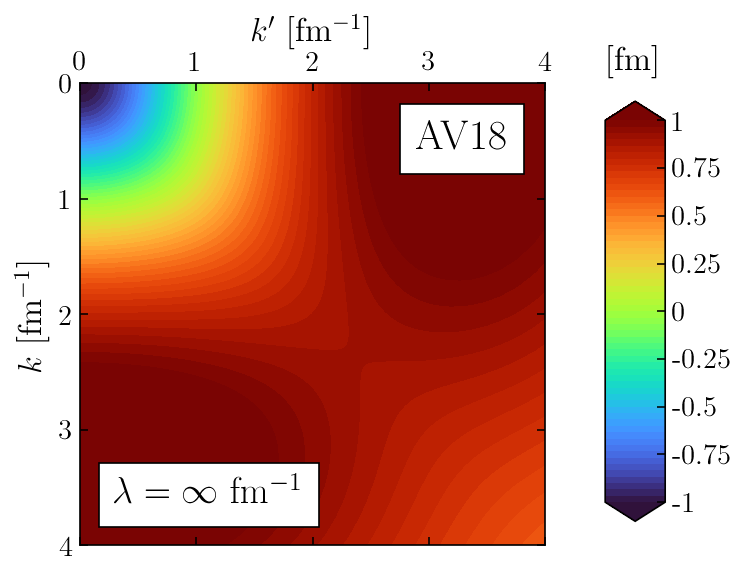

In [8]:
potential_contour(kvnn, channel, kmax, kmid, ntot, kvnn_label=True,
                  lambda_label=True)

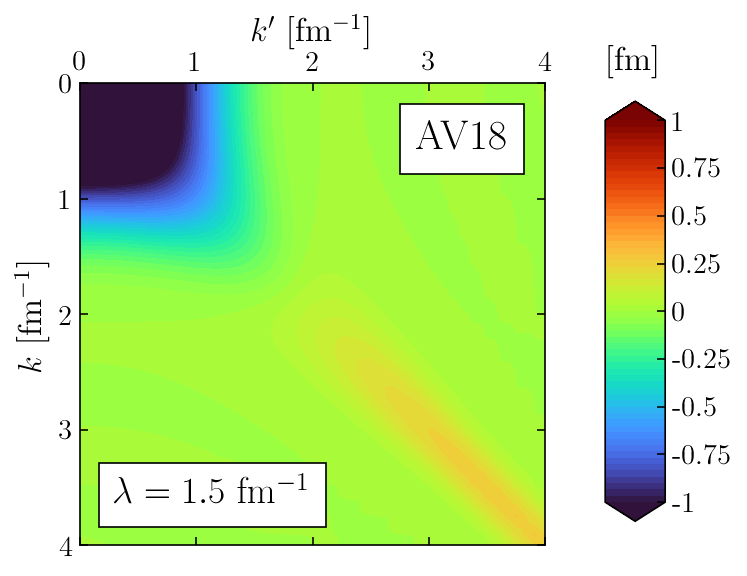

In [9]:
potential_contour(kvnn, channel, kmax, kmid, ntot, 'Wegner', 1.5,
                  kvnn_label=True, lambda_label=True)

## Snapshots of SRG evolution (multiple columns)

AV18 in the $^{1}{\rm P}_1$ channel under Wegner evolution. Here we show the unevolved potential $\lambda=\infty$ and several SRG-evolved potentials.

In [10]:
kvnn = 6
channel = '1P1'
kmax, kmid, ntot = 15.0, 3.0, 120
lambdas = (np.inf, 6.0, 3.0, 1.5)

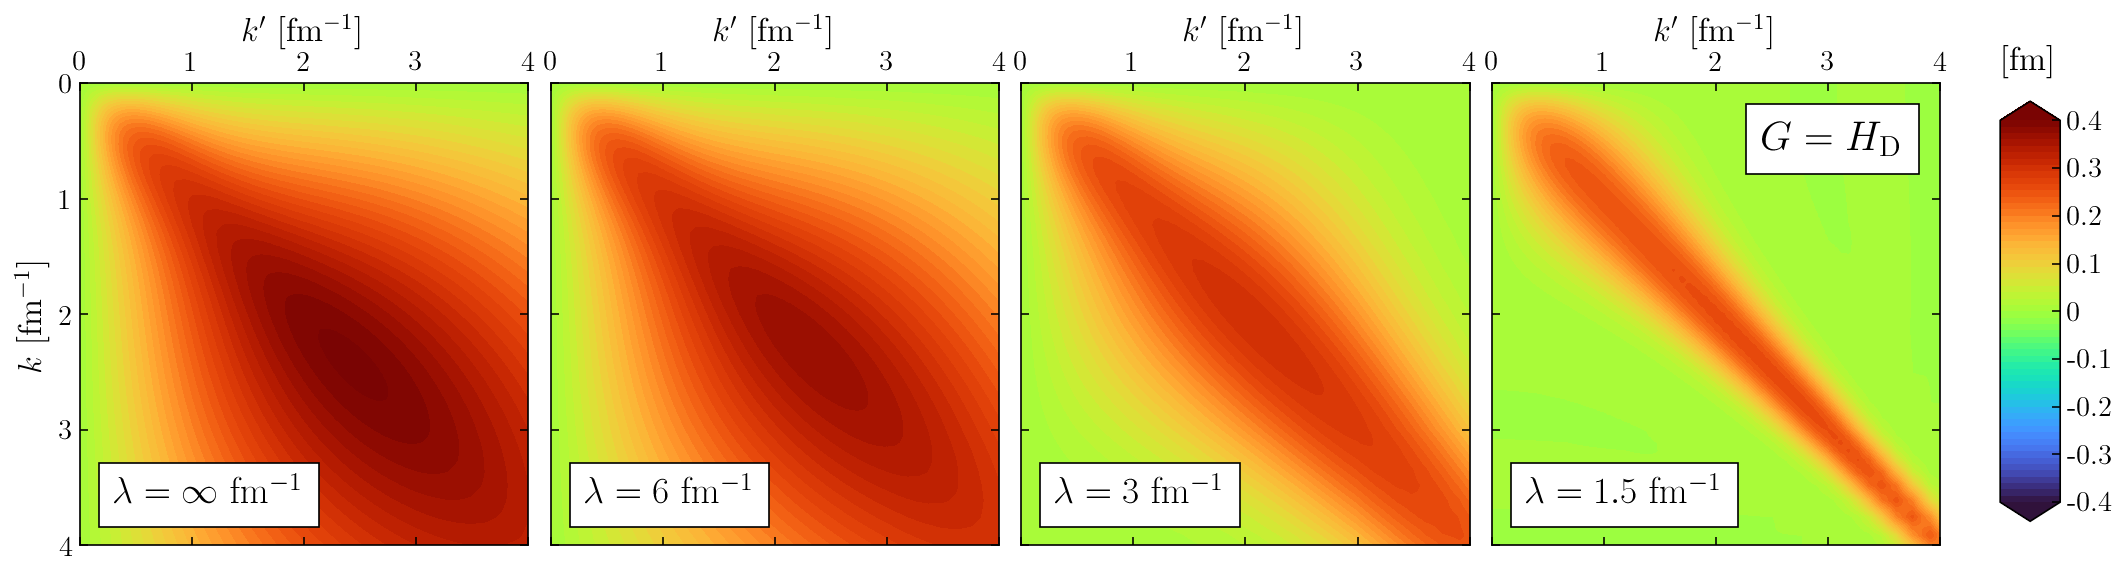

In [11]:
multiple_potential_contours(
    kvnn, channel, kmax, kmid, ntot, 'Wegner', lambdas,
    colorbar_limits=(-0.4,0.4), generator_label=True, lambda_label=True,
    save=True
)

Same case as above but with block-diagonal evolution fixing $\lambda=1$ fm$^{-1}$.

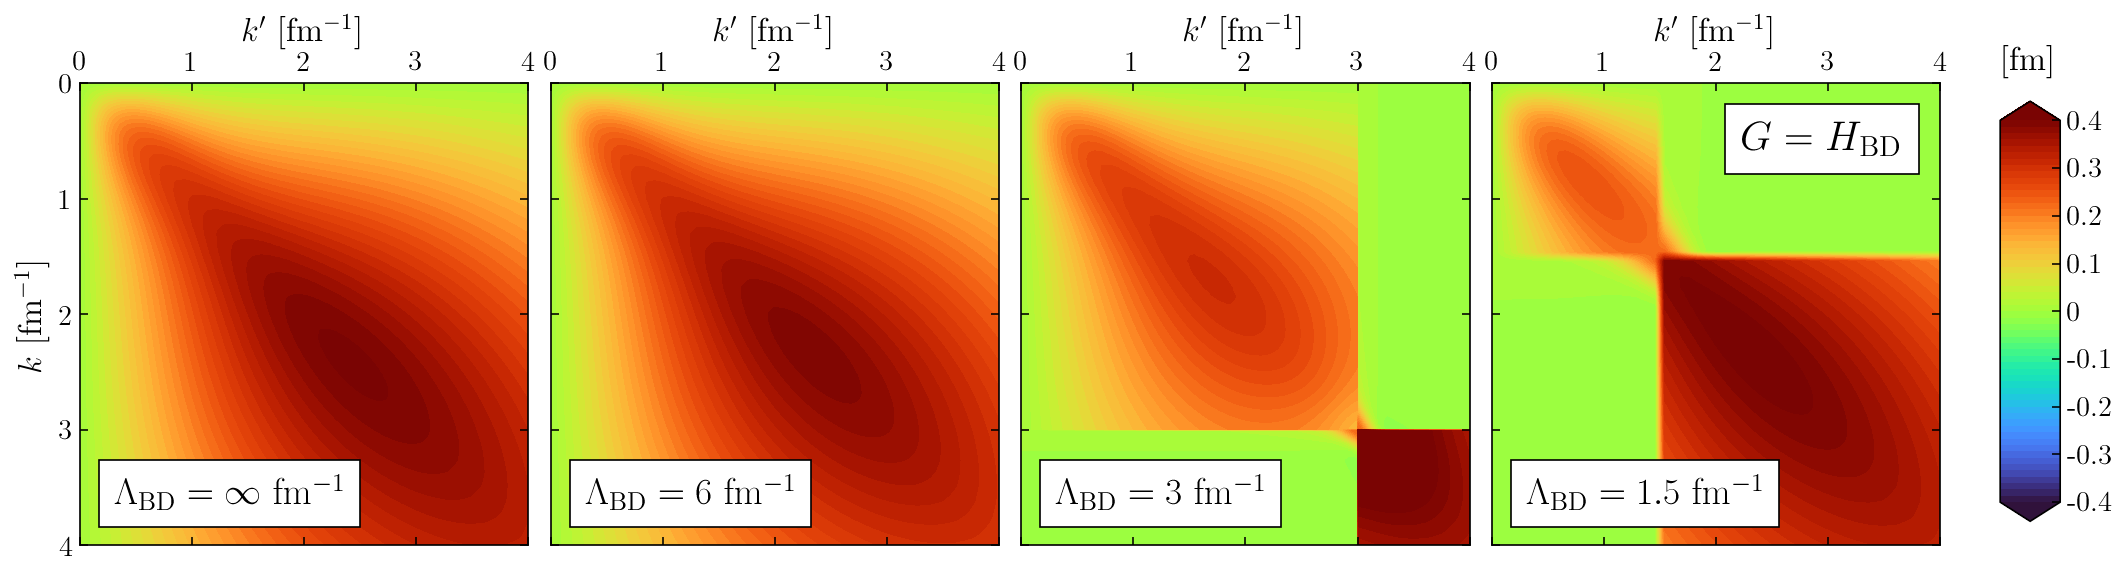

In [12]:
multiple_potential_contours(
    kvnn, channel, kmax, kmid, ntot, 'Block-diag', lambdas,
    colorbar_limits=(-0.4,0.4), generator_label=True, lambda_label=True,
    save=True
)